## Updated notebook to implement martin's solution :
https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563/output
https://github.com/radekosmulski/whale/blob/master/siamese_network_prototype.ipynb

I have removed various unused functions from previous versions. Also i have implemented on_epcoh_end() functionality to change data loader at the end of each epoch

In [1]:
# Suppress annoying stderr output when importing keras.
import sys
import platform
old_stderr = sys.stderr
sys.stderr = open('/dev/null' if platform.system() != 'Windows' else 'nul', 'w')

sys.stderr = old_stderr

import random
from scipy.ndimage import affine_transform

import pickle
import numpy as np
from math import sqrt

# Determise the size of each image
from os.path import isfile
from PIL import Image as pil_image
from tqdm import tqdm_notebook

from pandas import read_csv
import pandas as pd

In [2]:
from IPython.core.debugger import set_trace
import random
from lap import lapjv

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from fastai.vision import *
from fastai.metrics import accuracy_thresh
from fastai.basic_data import *
from torch.utils.data import DataLoader, Dataset
from torch import nn
from fastai.callbacks.hooks import num_features_model, model_sizes
from fastai.layers import BCEWithLogitsFlat
from fastai.basic_train import Learner
from skimage.util import montage
import pandas as pd
from torch import optim
import re

from utils import *

from IPython.core.debugger import set_trace
from functional import seq


In [4]:
df = pd.read_csv('data/whale/train.csv')
im_count = df[df.Id != 'new_whale'].Id.value_counts()
im_count.name = 'sighting_count'
df = df.join(im_count, on='Id')
print(df.shape)
df.head(1)

(25361, 3)


,Image,Id,sighting_count
0,0000e88ab.jpg,w_f48451c,14.0


In [5]:
exc_df = df[(df['Id']=='new_whale') | (df['sighting_count']==1)]
print(exc_df.shape)
df1 = df[df['Id']=='new_whale'].sample(frac= 0.1 , random_state = 42)
df2 = df[df['sighting_count']==1].sample(frac = 0.1 , random_state = 42)
print(df1.shape)
print(df2.shape)
print('use these 1173 images on final validation data')
val_exc_df = pd.concat([df1 , df2] , axis = 0)

(11737, 3)
(966, 3)
(207, 3)
use these 1173 images on final validation data


I am using on black and white images now ( because training on B/W images is giving better results from experiments)
Training data consists of all categories excluding new whale categories and categories having just 1 image data. Out of images with new whale category and 1 image data , i am creating 10% data which can be used for final validation ( and for finding out new whale threshold ).

Apart from this i am creating a 400 images , validation data set . It consist stratified sampling based upon whale category , having at most 10% images in validation and rest in training data.

In [6]:
new_df = df[df['Id']!= 'new_whale']
new_df = new_df[new_df['sighting_count']>1]
new_df_selected  = new_df[new_df['sighting_count']>10]
new_df_selected.shape
new_df_selected.drop(columns=['sighting_count'] , inplace=True)

validation = new_df_selected.groupby(['Id']).apply(lambda x: x.sample(frac = 0.1)).reset_index(drop= True)
print(new_df.shape)
print(validation.shape)

validation = validation.iloc[:400]
print(validation.shape)
val_imgs = set(validation.Image.values)
validation.to_csv(f'data/whale/martin_score_update_validation.csv', index=False)
#validation = pd.read_csv('data/whale/martin_score_update_validation.csv')

/home/FRACTAL/jitesh.arora/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
new_df.reset_index(drop=True)
new_df.drop(columns=['sighting_count'] , inplace=True)
print(new_df.shape)


(13624, 2)


In [7]:
SZ = 384
def expand_path(p):
    if isfile('data/whale/train-{SZ}/' + p): return 'data/whale/train-{SZ}/' + p
    if isfile('data/whale/test-{SZ}/' + p): return 'data/whale/test-{SZ}/' + p
    return p


def read_raw_image(p):
    img = pil_image.open(expand_path(p))
    return img


In [8]:
name = f'resnet18_sr_update_384_bw_img'

fn2label = {row[1].Image: row[1].Id for row in df.iterrows()}  #new_
path2fn = lambda path: re.search('\w*\.jpg$', path).group(0)

val_fns = set(validation.Image)
print('length of validation data: '  , len(val_fns))

SZ = 384
BS = 64//8
NUM_WORKERS = 12
SEED=0

length of validation data:  400


In [11]:
classes = df.Id.unique()
org_data = (
    ImageItemList  
        .from_df(new_df, f'data/whale/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns) 
        .label_from_func(lambda path: fn2label[path2fn(path)] ,  classes=classes)
        .add_test(ImageItemList.from_folder(f'data/whale/test-{SZ}'))
        .transform(get_transforms(do_flip=False), size=SZ, resize_method=ResizeMethod.SQUISH))

In [12]:
print(len(org_data.train))
print(len(org_data.valid))

13224
400


TwoImDataset creation is the part where I am trying to replicate 'TrainingData Class' from https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563/output
For whale categories having just one images in training data , matching pair -  same image pair (A,A) . For other categories it creates a de arrangement.  

In [13]:
def is_even(num): return num % 2 == 0

class TwoImDataset(Dataset):
    def __init__(self, ds ,score, steps = 10):
        self.ds = ds
        self.whale_ids = ds.y.items
        self.steps =steps
        self.score  = -score
       
        for item in np.unique(ds.y.items):
            candidates = list(np.where(self.whale_ids == item)[0])
            for i in candidates:
                for j in candidates:
                    self.score[i,j] = 10000.0
    
        self.on_epoch_end()
        
    def __len__(self):  return 2 * len(self.ds)
    def __getitem__(self, idx):
        if is_even(idx):
            return self.sample_image(idx // 2 , 1)
        else: return self.sample_image((idx-1) // 2 ,0)        

    def sample_image(self, idx , tag):
        #set_trace()
        if tag==1:
            first_image_id =  self.match[idx][0] ;  second_image_id = self.match[idx][1]
            if first_image_id == second_image_id:
                return self.sample_image((2*idx -1)//2 , 0)
            else:        
                return self.construct_example(self.ds[first_image_id][0], self.ds[second_image_id][0], 1)
        else:
            first_image_id =  self.unmatch[idx][0] ;  second_image_id = self.unmatch[idx][1]     
            return self.construct_example(self.ds[first_image_id][0], self.ds[second_image_id][0], 0)
  
    def on_epoch_end(self):
        if self.steps <= 0: return # Skip this on the last epoch.
        self.steps     -= 1 ; self.match      = [] ;  self.unmatch    = []
        print('steps left: ' , self.steps)
        _,_,x = lapjv(self.score) # Solve the linear assignment problem
        y = np.arange(len(x),dtype=np.int32)

        # Compute a derangement for matching whales
        ct = 0 
        for item in np.unique(self.whale_ids):
            candidates = list(np.where(self.whale_ids == item)[0])
            d = candidates.copy()
            if (len(d)==1): self.match.append((d[0] , d[0]))
            else:
                while True:
                    random.shuffle(candidates)
                    if not np.any(candidates == d): break
                for a ,b in zip(d , candidates): self.match.append((a , b))  ##(self.ds[a][0],self.ds[b][0])

        # Construct unmatched whale pairs from the LAP solution.
        for i,j in zip(x,y):
            if i == j: print(i,j)
            assert i != j
            self.unmatch.append(( i , j) )  #

        self.score[x,y] = 10000.0; self.score[y,x] = 10000.0
        random.shuffle(self.match) ;  random.shuffle(self.unmatch); #print('end of epoch , matching pair',self.match[0]) ; print('end of epoch , unmathcing pair ',self.unmatch[0])
        #print(len(self.match), len(self.ds), len(self.unmatch), len(self.ds))
        #assert len(self.match) == len(train) and len(self.unmatch) == len(train)
    
    def construct_example(self, im_A, im_B, class_idx):
        return [im_A, im_B], class_idx

In [14]:
%%time
tr_score = np.random.random_sample(size=(len(org_data.train),len(org_data.train)))
val_score = np.random.random_sample(size= (len(org_data.valid),len(org_data.valid)))
train_dl = DataLoader(
    TwoImDataset(org_data.train , tr_score, 16),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)

valid_dl = DataLoader(
    TwoImDataset(org_data.valid , val_score,400),
    batch_size=BS,
    shuffle=True,
    num_workers=NUM_WORKERS
)

steps left:  15
steps left:  399
CPU times: user 45.1 s, sys: 968 ms, total: 46.1 s
Wall time: 1min 1s


In [15]:
def normalize_batch(batch):
    stat_tensors = [torch.tensor(l).cuda() for l in imagenet_stats]
    return [normalize(batch[0][0], *stat_tensors), normalize(batch[0][1], *stat_tensors)], batch[1]

In [16]:
data_bunch = ImageDataBunch(train_dl , valid_dl) 
data_bunch.add_tfm(normalize_batch)

In [17]:
from functional import seq

class SiameseNetwork(nn.Module):
    def __init__(self, arch=models.resnet18):
        super().__init__() 
        self.cnn = create_body(arch)
        self.head = nn.Linear(num_features_model(self.cnn), 1)
        
    def forward(self, im_A, im_B):
        # dl - distance layer
        x1, x2 = seq(im_A, im_B).map(self.cnn).map(self.process_features)
        dl = self.calculate_distance(x1, x2)
        out = self.head(dl)
        return out
    
    def process_features(self, x): return x.reshape(*x.shape[:2], -1).max(-1)[0]
    def calculate_distance(self, x1, x2): return (x1 - x2).abs_()

In [18]:
@dataclass
class UpdateScoreMatrix(LearnerCallback):

    def on_epoch_end(self, **kwargs):
        learn.data.train_dl.dataset.on_epoch_end()
       

In [21]:
learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), 
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)],
               callback_fns=[UpdateScoreMatrix])

In [22]:
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])

In [30]:
"""
using previously trained network for transfer learning
"""
learn.load(f'siamene_d1_18_score_updates-stage12');
learn.freeze_to(-1)
learn.fit_one_cycle(4 , 3e-3)

epoch,train_loss,valid_loss,
1,0.183070,0.163681,0.922500
2,0.222802,0.157088,0.940000
3,0.135524,0.141094,0.938750
4,0.115331,0.119380,0.953750


steps left:  13
steps left:  12
steps left:  11
steps left:  10


steps left:  6
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


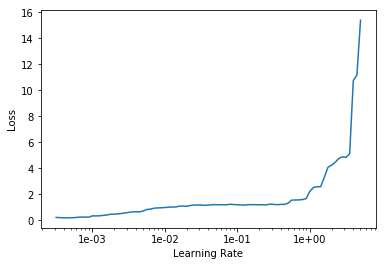

In [36]:
learn.unfreeze()
learn.lr_find(start_lr=1e-4 ,stop_div=False)
learn.recorder.plot()

In [37]:
max_lr = 3e-3
lrs = [max_lr/100, max_lr/10, max_lr]

In [38]:
learn.fit_one_cycle(6, lrs)

epoch,train_loss,valid_loss,
1,0.259490,0.181150,0.907500
2,0.262223,0.218057,0.893750
3,0.180557,0.195193,0.897500
4,0.166722,0.124803,0.947500
5,0.108651,0.102056,0.970000
6,0.103830,0.096633,0.967500


steps left:  5
steps left:  4
steps left:  3
steps left:  2
steps left:  1
steps left:  0


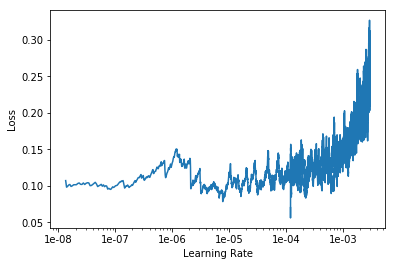

In [39]:
learn.recorder.plot()

In [44]:
name = f'resnet18_sr_update_384_bw_img'

In [45]:
learn.save(f'{name}-stage1')

After running models for few epochs, i want to update score matrix used in TwoImDataset. In order to come up with socres, currently i have a brute force approach of coming up with N X N array which has score of each example with respect to each of the other training examples.  
Defining functions for the same.

In [46]:
new_data = ( ImageItemList
        .from_df( new_df[(new_df.Id != 'new_whale')] , f'data/whale/train-{SZ}', cols=['Image'])
        .split_by_valid_func(lambda path: path2fn(path) in val_fns) # in newer version of the fastai library there is .no_split that could be used here
        .label_from_func(lambda path: fn2label[path2fn(path)], classes=classes)
        .add_test(ImageItemList.from_folder(f'data/whale/test-{SZ}'))
        .transform(None, size=SZ, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS, num_workers=NUM_WORKERS, path='data')
        .normalize(imagenet_stats))



def score_generation(learn , new_data):
    features = []
    train_class_idxs = []
    learn.model.eval()
    for ims, t in new_data.train_dl:
        features.append(learn.model.process_features(learn.model.cnn(ims)).detach().cpu())
        train_class_idxs.append(t)

    train_class_idxs = torch.cat(train_class_idxs)
    features = torch.cat(features)
    print(len(features))

    sims_np = []
    for feat in features:
        dists = learn.model.calculate_distance(features, feat.unsqueeze(0).repeat(13224, 1))
        predicted_similarity = learn.model.head(dists.cuda()).sigmoid_()  #.cuda()
        curr_sim = predicted_similarity.squeeze().detach().cpu()
        sims_np.append(curr_sim.numpy())

    sims_np = np.asarray(sims_np)
    return sims_np

Now following Martin's step: 
1. come up with score matrix , combination of original score and random array( randomized with some amplitude).
2. learn with following values of K for around 5 epochs
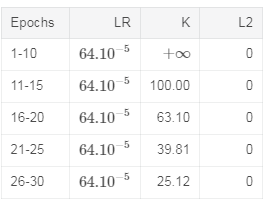

In [50]:

ampl = 100.0
sims_np = score_generation(learn , new_data)
score = sims_np.copy() + np.array(ampl*np.random.random_sample(size = (13224 , 13224)))

train_dl = DataLoader(TwoImDataset(org_data.train , score , steps = 10),batch_size=BS,shuffle=True, num_workers=NUM_WORKERS)
data_bunch = ImageDataBunch(train_dl , valid_dl) 
data_bunch.add_tfm(normalize_batch)

learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(),
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)], 
                callback_fns=[UpdateScoreMatrix])
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])
learn.freeze_to(-1)
learn.load(f'{name}-stage1')
learn.fit_one_cycle(4 , 1e-3)
learn.unfreeze()
max_lr = 5e-4
lrs = [max_lr/100, max_lr/10, max_lr]
learn.fit_one_cycle(6, lrs)
learn.save(f'{name}-stage2')

13224
steps left:  9


epoch,train_loss,valid_loss,
1,0.129625,0.126522,0.953750
2,0.135960,0.099606,0.966250
3,0.110901,0.091512,0.967500
4,0.108193,0.089160,0.968750


steps left:  8
steps left:  7
steps left:  6
steps left:  5


epoch,train_loss,valid_loss,
1,0.116499,0.098378,0.966250
2,0.117175,0.095079,0.967500
3,0.103697,0.094473,0.955000
4,0.077408,0.090068,0.957500
5,0.076640,0.085204,0.963750
6,0.068598,0.085550,0.958750


steps left:  4
steps left:  3
steps left:  2
steps left:  1
steps left:  0


In [51]:
ampl = 63.10
sims_np = score_generation(learn , new_data)
score = sims_np.copy() + np.array(ampl*np.random.random_sample(size= (13224 , 13224)))

train_dl = DataLoader(TwoImDataset(org_data.train , score  , steps =10),batch_size=BS,shuffle=True, num_workers=NUM_WORKERS)
data_bunch = ImageDataBunch(train_dl , valid_dl) 
data_bunch.add_tfm(normalize_batch)

learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), 
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)], 
                callback_fns=[UpdateScoreMatrix])
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])
learn.freeze_to(-1)
learn.load(f'{name}-stage2')
learn.fit_one_cycle(4 , 1e-3)
learn.unfreeze()
max_lr = 5e-4
lrs = [max_lr/100, max_lr/10, max_lr]
learn.fit_one_cycle(6, lrs)
learn.save(f'{name}-stage3')

13224
steps left:  9


epoch,train_loss,valid_loss,
1,0.116707,0.100269,0.962500
2,0.110346,0.092963,0.960000
3,0.096555,0.090480,0.960000
4,0.101610,0.080699,0.965000


steps left:  8
steps left:  7
steps left:  6
steps left:  5


epoch,train_loss,valid_loss,
1,0.082154,0.082177,0.962500
2,0.083976,0.102529,0.953750
3,0.093749,0.088888,0.962500
4,0.058409,0.086947,0.967500
5,0.085624,0.083280,0.965000
6,0.065744,0.082349,0.963750


steps left:  4
steps left:  3
steps left:  2
steps left:  1
steps left:  0


In [ ]:
learn.recorder.plot_losses()

In [52]:
ampl = 39.81
sims_np = score_generation(learn , new_data)
score = sims_np.copy() + np.array(ampl*np.random.random_sample(size=score.shape))

train_dl = DataLoader(TwoImDataset(org_data.train , score ,steps = 10),batch_size=BS,shuffle=True, num_workers=NUM_WORKERS)
data_bunch = ImageDataBunch(train_dl , valid_dl) 
data_bunch.add_tfm(normalize_batch)

learn = Learner(data_bunch, SiameseNetwork(), loss_func=BCEWithLogitsFlat(), 
                metrics=[lambda preds, targs: accuracy_thresh(preds.squeeze(), targs, sigmoid=False)], 
                callback_fns=[UpdateScoreMatrix])
learn.split([learn.model.cnn[:6], learn.model.cnn[6:], learn.model.head])
learn.freeze_to(-1)
learn.load(f'{name}-stage3')
learn.fit_one_cycle(4 , 1e-2)
learn.unfreeze()
max_lr = 5e-3
lrs = [max_lr/100, max_lr/10, max_lr]
learn.fit_one_cycle(6, lrs)
learn.save(f'{name}-stage4');

13224
steps left:  9


epoch,train_loss,valid_loss,
1,0.105405,0.088874,0.972500
2,0.075071,0.099052,0.957500
3,0.071678,0.089600,0.955000
4,0.085147,0.085055,0.960000


steps left:  8
steps left:  7
steps left:  6
steps left:  5


epoch,train_loss,valid_loss,
1,0.069484,0.090404,0.956250
2,0.068010,0.079819,0.966250
3,0.056548,0.080968,0.967500
4,0.072881,0.075425,0.961250
5,0.057068,0.080994,0.963750
6,0.053492,0.078342,0.970000


steps left:  4
steps left:  3
steps left:  2
steps left:  1
steps left:  0


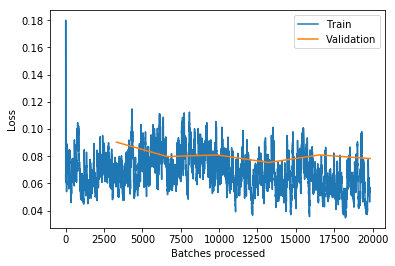

In [54]:
learn.recorder.plot_losses()

Following Martin's value  till around 40 epochs have not helped. Because our training loss is not decreasing. Maybe updating the DataLoader at the end of each epoch is not helping that much in my case because I don't have good base model to start with. 